# The second CNN
<b> Load the balanced and encoded data from the from the pickled DataFrame</b>

In [1]:
import pickle
import pandas as pd
import numpy as np

df_balanced = pickle.load( open("df_balanced_enc.pickle", "rb") )
#df_balanced

<b> Create a 80/20 train test split. You can use only the column with the one hot encoded sequences</b>

In [2]:
from sklearn.model_selection import train_test_split

rnd_seed=42
xTrain, xTest, yTrain, yTest = train_test_split( df_balanced.seq_oh_pad, df_balanced.lbl_num, test_size=0.2, random_state=rnd_seed )

## Create the second model
The second model is an extension of the first model with some slight changes.<br>
<li>A Conv1D layer with 16 filters of size 7</li>
<li>A Max pooling layer with factor 2</li>
<li>A Conv1D layer with 8 filters of size 7</li>
<li>A Max pooling layer with factor 2</li>
The remaining layers and properties are like the first model.<br>
As before this should be a function that returns the compiled model

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils

def create_second_model(input_shape, learning_rate=0.01, verbose=0):
    # create the model
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(16, 7, activation='relu', padding='same', input_shape=input_shape))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Conv1D(8, 7, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Flatten()) 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9, lr=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
    
    return model


## Second model with one hot encoded sequences
This time we are going to use some other features of the model.fit() function:
<li>The fit() function has a parameter validation_split, which will split of some data to be use for validation during training. Set this to 0.2</li>
<li>The fit() function returns an history object containing information about the training process</li>
<li>We are going to train for 100 epochs with a batch_size of 32</li>
<b> Create a KerasClassifier, train the model using the one hot encoded training data and save the training history.<br>
Create a classification report and the MCC for the performance on the test data.</b>

In [4]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, matthews_corrcoef

epochs=100
batch_size=32

model = KerasClassifier(build_fn=create_second_model, input_shape=(1004,5), verbose=1)
history1 = model.fit(np.array(xTrain.to_list()).reshape(-1,1004,5), yTrain.to_numpy(),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=0,
                    validation_split=0.2)

yPred = model.predict(np.array(xTest.to_list()).reshape(-1,1004,5))
print(classification_report( yTest.to_list(), yPred ))
print("MCC: ", matthews_corrcoef(yTest.to_list(), yPred))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1004, 16)          576       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 502, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 502, 8)            904       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 251, 8)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2008)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2009      
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
______________________________________________________

What do you notice when comparing this to our first model?<br>
Let's have look at the training history.<br>
<b>Create line plots for all metrics in the history using matplotlib.pyplot. What do you observe?</b>

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    ax = plt.subplot()
    ax.plot(history1.history['accuracy'], label='train acc')
    ax.plot(history.history['val_accuracy'], label='val acc')
    ax.plot(history.history['loss'], label='train loss')
    ax.plot(history.history['val_loss'], label='val loss')
    ax.set_ylim(0,1.1)
    ax.grid(True)
    plt.legend()
    plt.show()


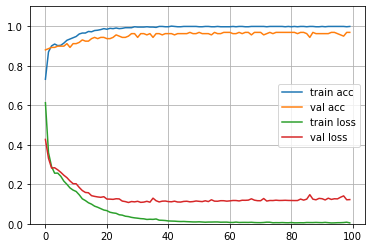

In [6]:
plot_history(history1)

# Reduce overfitting
It seems like our model might be overfitting a bit.<br>
<b> Create another model (i.e a function returning a model) but this time include a Dropout layer with rate 0.2 just before the output layer</b>

In [7]:
def create_second_model_dropout(input_shape, learning_rate=0.01, dropout=0.3, verbose=0):
    # create the model
    model = keras.Sequential()
    model.add(keras.layers.Conv1D(16, 7, activation='relu', padding='same', input_shape=input_shape))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Conv1D(8, 7, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Flatten())    
    model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.SGD(momentum=0.9, lr=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
    
    return model

<b>Train and evaluate the model with dropout using the test data. Plot the training history.</b>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1004, 16)          576       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 502, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 502, 8)            904       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 251, 8)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2008)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2008)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

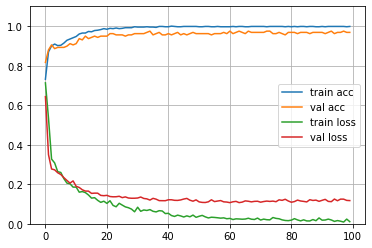

In [8]:
import pandas as pd
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, matthews_corrcoef

epochs=100
batch_size=32

model = KerasClassifier(build_fn=create_second_model_dropout, input_shape=(1004,5), learning_rate=0.01, verbose=1)
history_drop = model.fit(np.array(xTrain.to_list()).reshape(-1,1004,5), yTrain.to_numpy(),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=0,
                    validation_split=0.2)

yPred = model.predict(np.array(xTest.to_list()).reshape(-1,1004,5))
print(classification_report( yTest.to_list(), yPred ))
print("MCC: ", matthews_corrcoef(yTest.to_list(), yPred))

plot_history(history_drop)

## GridSearchCV for learning_rate and epochs
The dropout seems to help against the overfitting. Explore the effects of different dropout rates and learning rates (an important hyper parameter) using GridSearchCV from scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).<br>
<b>Search with learning rates = 0.001, 0.01, 0.05, 0.1 and a reasonable number of dropout rates between 0.1 and 0.9. Use 3 or 5 fold cross validation and score using the f1 score.<br>Print out the best score and the corresponding parameters</b>

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_second_model_dropout, input_shape=(1004,5), epochs=60, verbose=0)

# define the grid search parameters
#rates = [0.001, 0.01, 0.05, 0.1]
rates = [0.001]
#dropouts = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
dropouts = [0.2]


param_grid = dict(learning_rate=rates, dropout=dropouts)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1", cv=2, n_jobs=-1, verbose=10)
grid_result = grid.fit(np.array(xTrain.to_list()).reshape(-1,1004,5), yTrain.to_numpy())

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6)}

<b> Print out the results (mean_test_score, std_test_score and corresponding params) for all parameter combinations</b>

In [11]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'grid_result' is not defined

## Visualize gridsearch
<b>To visualize the results of the grid search create a DataFrame with columns for the mean_test_scores, the epochs and the learning rates.<br> Then use the pivot_table function to create a matrix that can be visualized via a seaborn.heatmap</b>

In [12]:
import seaborn as sns

mean_scores = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
rates = [d["learning_rate"] for d in params]
dropouts = [d["dropout"] for d in params]

df_gridsearch = pd.DataFrame(zip(mean_scores, rates, dropouts), columns=["mean_test_score","learning_rate","dropout"])
df_grid_piv = df_gridsearch.pivot_table(index="learning_rate", columns="dropout").droplevel(axis="columns", level=0)

sns.heatmap(df_grid_piv, annot=True, cmap="Blues"); #annot=True to annotate cells

NameError: name 'grid_result' is not defined

## Retrain the model
<b>Train the model using the parameters found in the grid search. Plot all metrics in the training history and print out classification report and MCC for the test data</b>

In [9]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, matthews_corrcoef

epochs=60
batch_size=32

model = KerasClassifier(build_fn=create_second_model_dropout, input_shape=(1004,5), learning_rate=0.01, dropout=0.5, verbose=0)
history2 = model.fit(np.array(xTrain.to_list()).reshape(-1,1004,5), yTrain.to_numpy(),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=0,
                    validation_split=0.2)

yPred = model.predict(np.array(xTest.to_list()).reshape(-1,1004,5))
print(classification_report( yTest.to_list(), yPred ))
print("MCC: ", matthews_corrcoef(yTest.to_list(), yPred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        99
           1       0.96      0.95      0.95        98

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

MCC:  0.908669214187588


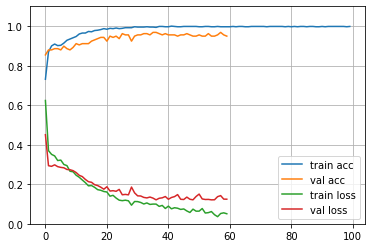

In [10]:
plot_history(history2)

## 10 fold cross validation
For an assessment of the stability perform a 10-fold cross validation. Train for a maximum of 50 epochs.<br>
<b>Collect the the training history, MCC, F1 score and accuracy from each round and calculate their mean values</b>

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, f1_score, accuracy_score

epochs=50
splits=2
#to save scores
df_scores = pd.DataFrame(columns=["mcc", "f1","acc"])
df_scores.index.name = "Round"

# to save histories
histories = []

# define 10-fold cross validation test 
kfold = StratifiedKFold(n_splits=splits, shuffle=True)

for i, (train_index, test_index) in enumerate(kfold.split(xTrain, yTrain)):
    
    # get the splits
    X_train, X_test = xTrain.iloc[train_index], xTrain.iloc[test_index]
    y_train, y_test = yTrain.iloc[train_index], yTrain.iloc[test_index]

    # train one hot 
    model_cv = KerasClassifier(build_fn=create_second_model_dropout, input_shape=(1004,5), learning_rate=0.01, dropout=0.5, verbose=0)
    hist = model_cv.fit(np.array(X_train.to_list()).reshape(-1,1004,5), y_train.to_numpy(), epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2) # start training
    yPred = model_cv.predict(np.array(X_test.to_list()).reshape(-1,1004,5))
    
    # save predictions
    df_scores.loc[i] = [matthews_corrcoef(y_test.to_list(), yPred),
                        f1_score(y_test.to_list(), yPred),
                        accuracy_score(y_test.to_list(), yPred)]
    # save history
    histories.append(hist)
    
    print("Finished round {}".format(i))
    
df_scores.loc['mean'] = df_scores.mean()
df_scores

Finished round 0
Finished round 1


,mcc,f1,acc
Round,,,
0,0.903565,0.951899,0.951777
1,0.863930,0.933333,0.931298
mean,0.883748,0.942616,0.941537


<b>Plot the training histories.</b>

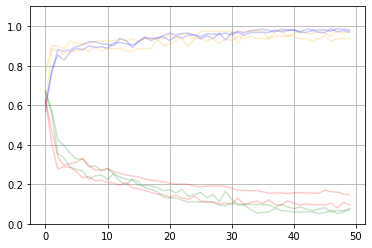

In [12]:
ax = plt.subplot()

for history in histories:
    ax.plot(history.history['accuracy'], label='train acc', color="blue", alpha=0.2)
    ax.plot(history.history['val_accuracy'], label='val acc', color="orange", alpha=0.2)
    ax.plot(history.history['loss'], label='train loss', color="green", alpha=0.2)
    ax.plot(history.history['val_loss'], label='val loss', color="red", alpha=0.2)
ax.set_ylim(0,1.1)
ax.grid(True)
#plt.legend()
plt.show()

## Confirm with test data
<b>Train the model without using a validation split and confirm the cross validation results on our test data</b>

In [13]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, matthews_corrcoef

epochs=20
batch_size=32

model = KerasClassifier(build_fn=create_second_model_dropout, input_shape=(1004,5), learning_rate=0.01, verbose=0)
history_drop = model.fit(np.array(xTrain.to_list()).reshape(-1,1004,5), yTrain.to_numpy(),
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=0)

yPred = model.predict(np.array(xTest.to_list()).reshape(-1,1004,5))
print(classification_report( yTest.to_list(), yPred ))
print("MCC: ", matthews_corrcoef(yTest.to_list(), yPred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97        99
           1       0.99      0.94      0.96        98

    accuracy                           0.96       197
   macro avg       0.97      0.96      0.96       197
weighted avg       0.97      0.96      0.96       197

MCC:  0.9301136370273199


## GOTO 04 # it's all you from here on 